In [1]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model.bin"

#file to download to run model:  
#1) https://howardhsu.github.io/dataset/ for domain embedding (need to download this!)

In [2]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [3]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

## No Clean

In [4]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task1.csv')

In [5]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [6]:
encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values

print('num of aspect tags: {}'.format(len(encoder.classes_)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2


0

In [7]:
print(len(sentences))
print(len(aspect_tags))

3501
3501


In [8]:
print(max(map(lambda x: len(x), sentences)))

84


In [9]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, aspect_tags, sent_len=83):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                mask[sx, wx] = 1
                train_y[sx, wx] = aspect_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, 2)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [10]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, domain_emb, num_classes=3, dropout=0.5):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.domain_embedding = torch.nn.Embedding(domain_emb.shape[0], domain_emb.shape[1])
        self.domain_embedding.weight = torch.nn.Parameter(torch.from_numpy(domain_emb), requires_grad=False)
        self.conv1 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 5, padding=2)
        self.conv2 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 3, padding=1)

        self.dropout = torch.nn.Dropout(dropout)

        self.conv3 = torch.nn.Conv1d(256, 256, 5, padding=2)
        self.conv4 = torch.nn.Conv1d(256, 256, 5, padding=2)

        self.lstm = nn.LSTM(256, hidden_size=128, num_layers=1, bidirectional=True, batch_first=True)

        self.linear_ae = torch.nn.Linear(256, num_classes)

    def forward(self, x_train):
        x_emb = torch.cat((self.gen_embedding(x_train), self.domain_embedding(x_train)), dim=2)

        x_emb = self.dropout(x_emb).transpose(1, 2)

        x_conv = torch.nn.functional.relu(torch.cat((self.conv1(x_emb.float()), self.conv2(x_emb.float())), dim=1))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv3(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv4(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = x_conv.transpose(1, 2)

        x_lstm, (hidden, cell) = self.lstm(x_conv)

        x_logit = self.linear_ae(x_lstm)

        out = torch.nn.functional.softmax(x_logit)
        
        return out

In [11]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'restaurant_emb.vec'
res_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

fn = DATA_DIR + 'laptop_emb.vec'
lap_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

res_domain_embedding = np.concatenate([res_domain_embedding, lap_domain_embedding], axis=0)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, aspect_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [12]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_ASPECT_TAGS = 2

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding, res_domain_embedding, num_classes=2), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [13]:
history = {
    "train_loss": list(),
    "aspact_train_acc": list(),
    "valid_loss": list(),
    "aspact_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()

        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['aspact_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['aspact_valid_acc'].append(avg_test_acc.cpu().numpy())


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



epoch 0
	train_loss:0.693 valid_loss:0.693
	train_acc:68.51% valid_acc:72.53%
	train_f1:0.721 valid_f1:0.748
	train_confusion_matrix:
[[ 1981  4830]
 [10810 32046]]
	valid_confusion_matrix:
[[ 484 1279]
 [2239 8805]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



epoch 1
	train_loss:0.690 valid_loss:0.692
	train_acc:73.80% valid_acc:74.09%
	train_f1:0.757 valid_f1:0.758
	train_confusion_matrix:
[[ 1801  4989]
 [ 8065 34968]]
	valid_confusion_matrix:
[[ 447 1316]
 [2002 9042]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 2
	train_loss:0.687 valid_loss:0.691
	train_acc:76.04% valid_acc:76.53%
	train_f1:0.773 valid_f1:0.780
	train_confusion_matrix:
[[ 1884  4905]
 [ 6969 35800]]
	valid_confusion_matrix:
[[ 573 1190]
 [1816 9228]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



epoch 3
	train_loss:0.684 valid_loss:0.691
	train_acc:77.48% valid_acc:77.71%
	train_f1:0.789 valid_f1:0.792
	train_confusion_matrix:
[[ 2516  4280]
 [ 6904 35954]]
	valid_confusion_matrix:
[[ 680 1083]
 [1772 9272]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]



epoch 4
	train_loss:0.684 valid_loss:0.691
	train_acc:79.65% valid_acc:80.38%
	train_f1:0.806 valid_f1:0.811
	train_confusion_matrix:
[[ 2562  4204]
 [ 5914 37045]]
	valid_confusion_matrix:
[[ 679 1084]
 [1429 9615]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 5
	train_loss:0.683 valid_loss:0.690
	train_acc:80.89% valid_acc:82.13%
	train_f1:0.818 valid_f1:0.825
	train_confusion_matrix:
[[ 2910  3883]
 [ 5604 37243]]
	valid_confusion_matrix:
[[ 700 1063]
 [1226 9818]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]



epoch 6
	train_loss:0.682 valid_loss:0.690
	train_acc:82.34% valid_acc:83.24%
	train_f1:0.829 valid_f1:0.836
	train_confusion_matrix:
[[ 2980  3791]
 [ 4934 37703]]
	valid_confusion_matrix:
[[ 781  982]
 [1164 9880]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.29s/it]



epoch 7
	train_loss:0.682 valid_loss:0.690
	train_acc:83.06% valid_acc:83.58%
	train_f1:0.838 valid_f1:0.841
	train_confusion_matrix:
[[ 3438  3348]
 [ 5059 37779]]
	valid_confusion_matrix:
[[ 850  913]
 [1190 9854]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.25s/it]



epoch 8
	train_loss:0.681 valid_loss:0.690
	train_acc:84.29% valid_acc:83.48%
	train_f1:0.848 valid_f1:0.843
	train_confusion_matrix:
[[ 3528  3274]
 [ 4533 38359]]
	valid_confusion_matrix:
[[ 964  799]
 [1317 9727]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.42s/it]



epoch 9
	train_loss:0.681 valid_loss:0.690
	train_acc:84.68% valid_acc:83.85%
	train_f1:0.853 valid_f1:0.849
	train_confusion_matrix:
[[ 3762  3023]
 [ 4574 38226]]
	valid_confusion_matrix:
[[1086  677]
 [1391 9653]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



epoch 10
	train_loss:0.679 valid_loss:0.690
	train_acc:85.58% valid_acc:85.02%
	train_f1:0.862 valid_f1:0.859
	train_confusion_matrix:
[[ 3974  2818]
 [ 4332 38461]]
	valid_confusion_matrix:
[[1094  669]
 [1250 9794]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 11
	train_loss:0.679 valid_loss:0.690
	train_acc:86.25% valid_acc:86.73%
	train_f1:0.869 valid_f1:0.872
	train_confusion_matrix:
[[ 4209  2577]
 [ 4259 38677]]
	valid_confusion_matrix:
[[ 1059   704]
 [  995 10049]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.33s/it]



epoch 12
	train_loss:0.678 valid_loss:0.689
	train_acc:87.37% valid_acc:87.62%
	train_f1:0.878 valid_f1:0.881
	train_confusion_matrix:
[[ 4217  2564]
 [ 3705 39135]]
	valid_confusion_matrix:
[[ 1153   610]
 [  975 10069]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



epoch 13
	train_loss:0.678 valid_loss:0.689
	train_acc:88.27% valid_acc:89.13%
	train_f1:0.887 valid_f1:0.892
	train_confusion_matrix:
[[ 4574  2218]
 [ 3582 39059]]
	valid_confusion_matrix:
[[ 1104   659]
 [  733 10311]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



epoch 14
	train_loss:0.678 valid_loss:0.689
	train_acc:89.56% valid_acc:88.99%
	train_f1:0.897 valid_f1:0.892
	train_confusion_matrix:
[[ 4365  2382]
 [ 2792 40027]]
	valid_confusion_matrix:
[[ 1149   614]
 [  796 10248]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



epoch 15
	train_loss:0.677 valid_loss:0.689
	train_acc:89.34% valid_acc:90.36%
	train_f1:0.896 valid_f1:0.901
	train_confusion_matrix:
[[ 4482  2308]
 [ 2995 39946]]
	valid_confusion_matrix:
[[ 1044   719]
 [  515 10529]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



epoch 16
	train_loss:0.677 valid_loss:0.689
	train_acc:90.17% valid_acc:90.54%
	train_f1:0.903 valid_f1:0.904
	train_confusion_matrix:
[[ 4538  2270]
 [ 2624 40346]]
	valid_confusion_matrix:
[[ 1101   662]
 [  550 10494]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



epoch 17
	train_loss:0.677 valid_loss:0.689
	train_acc:90.43% valid_acc:91.31%
	train_f1:0.905 valid_f1:0.909
	train_confusion_matrix:
[[ 4483  2304]
 [ 2456 40492]]
	valid_confusion_matrix:
[[ 1033   730]
 [  383 10661]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]



epoch 18
	train_loss:0.677 valid_loss:0.689
	train_acc:90.85% valid_acc:91.05%
	train_f1:0.908 valid_f1:0.909
	train_confusion_matrix:
[[ 4494  2303]
 [ 2243 40645]]
	valid_confusion_matrix:
[[ 1134   629]
 [  517 10527]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


epoch 19
	train_loss:0.677 valid_loss:0.689
	train_acc:91.08% valid_acc:90.89%
	train_f1:0.910 valid_f1:0.909
	train_confusion_matrix:
[[ 4375  2414]
 [ 2007 40792]]
	valid_confusion_matrix:
[[ 1164   599]
 [  568 10476]]


(0.5, 1.0)

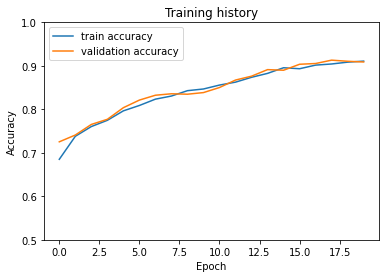

In [14]:
plt.plot(history['aspact_train_acc'], label='train accuracy')
plt.plot(history['aspact_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1])

In [15]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_aspect_tags.extend(pred_tags)
            final_true_aspect_tags.extend(label)

    final_pred_aspect_tags = torch.stack(final_pred_aspect_tags).cpu()
    final_true_aspect_tags = torch.stack(final_true_aspect_tags).cpu()
        
    print(classification_report(final_true_aspect_tags, final_pred_aspect_tags, 
                                target_names=encoder.classes_))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model.bin


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

              precision    recall  f1-score   support

          AT       0.76      0.65      0.70      1763
         NAT       0.95      0.97      0.96     11044

    accuracy                           0.92     12807
   macro avg       0.85      0.81      0.83     12807
weighted avg       0.92      0.92      0.92     12807



## Clean

In [16]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task1_cleaned.csv')

In [17]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [18]:
encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values

print('num of aspect tags: {}'.format(len(encoder.classes_)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2


0

In [19]:
print(len(sentences))
print(len(aspect_tags))

3501
3501


In [20]:
print(max(map(lambda x: len(x), sentences)))

80


In [21]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, aspect_tags, sent_len=83):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                mask[sx, wx] = 1
                train_y[sx, wx] = aspect_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, 2)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [22]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, domain_emb, num_classes=3, dropout=0.5):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.domain_embedding = torch.nn.Embedding(domain_emb.shape[0], domain_emb.shape[1])
        self.domain_embedding.weight = torch.nn.Parameter(torch.from_numpy(domain_emb), requires_grad=False)
        self.conv1 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 5, padding=2)
        self.conv2 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 3, padding=1)

        self.dropout = torch.nn.Dropout(dropout)

        self.conv3 = torch.nn.Conv1d(256, 256, 5, padding=2)
        self.conv4 = torch.nn.Conv1d(256, 256, 5, padding=2)

        self.lstm = nn.LSTM(256, hidden_size=128, num_layers=1, bidirectional=True, batch_first=True)

        self.linear_ae = torch.nn.Linear(256, num_classes)

    def forward(self, x_train):
        x_emb = torch.cat((self.gen_embedding(x_train), self.domain_embedding(x_train)), dim=2)

        x_emb = self.dropout(x_emb).transpose(1, 2)

        x_conv = torch.nn.functional.relu(torch.cat((self.conv1(x_emb.float()), self.conv2(x_emb.float())), dim=1))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv3(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv4(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = x_conv.transpose(1, 2)

        x_lstm, (hidden, cell) = self.lstm(x_conv)

        x_logit = self.linear_ae(x_lstm)

        out = torch.nn.functional.softmax(x_logit)
        
        return out

In [23]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'restaurant_emb.vec'
res_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

fn = DATA_DIR + 'laptop_emb.vec'
lap_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

res_domain_embedding = np.concatenate([res_domain_embedding, lap_domain_embedding], axis=0)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, aspect_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [24]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_ASPECT_TAGS = 2

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding, res_domain_embedding, num_classes=2), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [25]:
history = {
    "train_loss": list(),
    "aspact_train_acc": list(),
    "valid_loss": list(),
    "aspact_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()

        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['aspact_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['aspact_valid_acc'].append(avg_test_acc.cpu().numpy())


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.27s/it]



epoch 0
	train_loss:0.693 valid_loss:0.693
	train_acc:69.53% valid_acc:75.92%
	train_f1:0.719 valid_f1:0.765
	train_confusion_matrix:
[[ 1973  4770]
 [ 8356 27986]]
	valid_confusion_matrix:
[[ 458 1262]
 [1486 8208]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.34s/it]



epoch 1
	train_loss:0.689 valid_loss:0.692
	train_acc:75.55% valid_acc:77.19%
	train_f1:0.761 valid_f1:0.775
	train_confusion_matrix:
[[ 1802  4888]
 [ 5705 30937]]
	valid_confusion_matrix:
[[ 481 1239]
 [1364 8330]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 2
	train_loss:0.686 valid_loss:0.691
	train_acc:77.93% valid_acc:79.00%
	train_f1:0.782 valid_f1:0.793
	train_confusion_matrix:
[[ 2161  4554]
 [ 4983 31522]]
	valid_confusion_matrix:
[[ 590 1130]
 [1267 8427]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.27s/it]



epoch 3
	train_loss:0.684 valid_loss:0.691
	train_acc:78.53% valid_acc:80.59%
	train_f1:0.793 valid_f1:0.811
	train_confusion_matrix:
[[ 2740  3980]
 [ 5345 31359]]
	valid_confusion_matrix:
[[ 729  991]
 [1225 8469]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.25s/it]



epoch 4
	train_loss:0.683 valid_loss:0.691
	train_acc:80.83% valid_acc:81.90%
	train_f1:0.812 valid_f1:0.824
	train_confusion_matrix:
[[ 2918  3811]
 [ 4534 32267]]
	valid_confusion_matrix:
[[ 812  908]
 [1158 8536]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.24s/it]



epoch 5
	train_loss:0.682 valid_loss:0.691
	train_acc:81.75% valid_acc:83.22%
	train_f1:0.823 valid_f1:0.835
	train_confusion_matrix:
[[ 3311  3415]
 [ 4517 32222]]
	valid_confusion_matrix:
[[ 829  891]
 [1024 8670]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



epoch 6
	train_loss:0.682 valid_loss:0.691
	train_acc:82.70% valid_acc:83.66%
	train_f1:0.832 valid_f1:0.840
	train_confusion_matrix:
[[ 3454  3277]
 [ 4225 32416]]
	valid_confusion_matrix:
[[ 877  843]
 [1022 8672]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.37s/it]



epoch 7
	train_loss:0.681 valid_loss:0.690
	train_acc:83.69% valid_acc:84.37%
	train_f1:0.842 valid_f1:0.849
	train_confusion_matrix:
[[ 3718  3016]
 [ 4068 32621]]
	valid_confusion_matrix:
[[ 973  747]
 [1037 8657]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



epoch 8
	train_loss:0.680 valid_loss:0.690
	train_acc:84.14% valid_acc:85.37%
	train_f1:0.847 valid_f1:0.853
	train_confusion_matrix:
[[ 3913  2842]
 [ 4041 32611]]
	valid_confusion_matrix:
[[ 874  846]
 [ 824 8870]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



epoch 9
	train_loss:0.680 valid_loss:0.690
	train_acc:85.26% valid_acc:85.38%
	train_f1:0.856 valid_f1:0.858
	train_confusion_matrix:
[[ 3946  2772]
 [ 3610 32959]]
	valid_confusion_matrix:
[[1011  709]
 [ 960 8734]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.37s/it]



epoch 10
	train_loss:0.679 valid_loss:0.690
	train_acc:85.88% valid_acc:87.17%
	train_f1:0.862 valid_f1:0.870
	train_confusion_matrix:
[[ 4092  2633]
 [ 3478 33091]]
	valid_confusion_matrix:
[[ 931  789]
 [ 675 9019]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



epoch 11
	train_loss:0.679 valid_loss:0.690
	train_acc:86.36% valid_acc:87.02%
	train_f1:0.867 valid_f1:0.872
	train_confusion_matrix:
[[ 4270  2466]
 [ 3442 33136]]
	valid_confusion_matrix:
[[1027  693]
 [ 788 8906]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



epoch 12
	train_loss:0.678 valid_loss:0.690
	train_acc:87.28% valid_acc:87.52%
	train_f1:0.875 valid_f1:0.876
	train_confusion_matrix:
[[ 4312  2395]
 [ 3117 33520]]
	valid_confusion_matrix:
[[1049  671]
 [ 753 8941]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.24s/it]



epoch 13
	train_loss:0.678 valid_loss:0.690
	train_acc:87.65% valid_acc:88.23%
	train_f1:0.879 valid_f1:0.882
	train_confusion_matrix:
[[ 4428  2286]
 [ 3064 33536]]
	valid_confusion_matrix:
[[1048  672]
 [ 671 9023]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 14
	train_loss:0.677 valid_loss:0.690
	train_acc:88.36% valid_acc:88.22%
	train_f1:0.884 valid_f1:0.884
	train_confusion_matrix:
[[ 4179  2506]
 [ 2551 34202]]
	valid_confusion_matrix:
[[1111  609]
 [ 735 8959]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.33s/it]



epoch 15
	train_loss:0.677 valid_loss:0.690
	train_acc:88.93% valid_acc:87.94%
	train_f1:0.891 valid_f1:0.884
	train_confusion_matrix:
[[ 4510  2216]
 [ 2585 34076]]
	valid_confusion_matrix:
[[1194  526]
 [ 851 8843]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.43s/it]



epoch 16
	train_loss:0.677 valid_loss:0.689
	train_acc:89.30% valid_acc:89.20%
	train_f1:0.894 valid_f1:0.893
	train_confusion_matrix:
[[ 4576  2157]
 [ 2479 34130]]
	valid_confusion_matrix:
[[1128  592]
 [ 641 9053]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.29s/it]



epoch 17
	train_loss:0.677 valid_loss:0.689
	train_acc:89.71% valid_acc:89.44%
	train_f1:0.897 valid_f1:0.896
	train_confusion_matrix:
[[ 4472  2259]
 [ 2191 34317]]
	valid_confusion_matrix:
[[1163  557]
 [ 648 9046]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



epoch 18
	train_loss:0.677 valid_loss:0.690
	train_acc:90.32% valid_acc:89.57%
	train_f1:0.902 valid_f1:0.897
	train_confusion_matrix:
[[ 4467  2249]
 [ 1954 34752]]
	valid_confusion_matrix:
[[1192  528]
 [ 663 9031]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


epoch 19
	train_loss:0.677 valid_loss:0.689
	train_acc:90.14% valid_acc:90.63%
	train_f1:0.901 valid_f1:0.904
	train_confusion_matrix:
[[ 4502  2244]
 [ 2034 34618]]
	valid_confusion_matrix:
[[1103  617]
 [ 453 9241]]


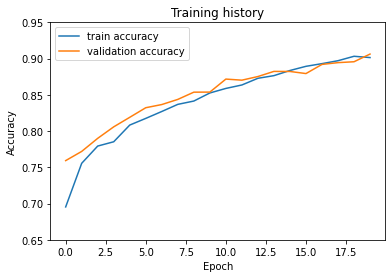

In [26]:
plt.plot(history['aspact_train_acc'], label='train accuracy')
plt.plot(history['aspact_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.65, 0.95])
plt.show()

In [27]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_aspect_tags.extend(pred_tags)
            final_true_aspect_tags.extend(label)

    final_pred_aspect_tags = torch.stack(final_pred_aspect_tags).cpu()
    final_true_aspect_tags = torch.stack(final_true_aspect_tags).cpu()
        
    print(classification_report(final_true_aspect_tags, final_pred_aspect_tags, 
                                target_names=encoder.classes_))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model.bin


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_15944/972914119.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(x_logit)
100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

              precision    recall  f1-score   support

          AT       0.74      0.71      0.73      1720
         NAT       0.95      0.96      0.95      9694

    accuracy                           0.92     11414
   macro avg       0.85      0.83      0.84     11414
weighted avg       0.92      0.92      0.92     11414

